In [1]:
using CSV
using DataFrames
using Statistics

using Plots
using StatsPlots, KernelDensity


In [2]:
#cd("/vf/users/saakyanh2/WD/fx/foldexity")
include("../src/fxio.jl")
include("../src/entropy.jl")


# Folding entropy

In [36]:
cpptraj("../../mdfolding/ubiq.pdb", 
        "../../mdfolding/ubiquitin.xtc", 20000, 30000, 10,
        "../../mdfolding/pdbtraj")


In [37]:
traj3di = structure2fs3di("../../mdfolding/pdbtraj")
traj3di = traj3di[!, [:id, :seqaa, :seq3di]]
transform!(traj3di, :id => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(traj3di, :id)
size(traj3di)

(1001, 3)

In [95]:
trajmu = structure2rsmu("../../mdfolding/pdbtraj")
transform!(trajmu, :id => ByRow(s -> parse(Int, split(basename(s),"_")[1])) => :id)
sort!(trajmu, :id)
size(trajmu)



reseek v2.3.i86linux64 [77bd409]
(C) Copyright 2024 Robert C. Edgar



[convert2mu ../../mdfolding/pdbtraj]
00:02 3.2Mb 1001 chains converted  (1001)   

00:02 3.2Mb (max 3.2Mb) finished


(1001, 2)

In [96]:
k=1
traj3di[!,:H1_fold ] = entropy_shannon.(traj3di.seq3di, k)
traj3di[!,:lz ] = lz76.(traj3di.seq3di, k)
trajmu[!,:H1_fold ] = entropy_shannon.(trajmu.seq, k)
trajmu[!,:lz ] = lz76.(trajmu.seq, k)
size(trajmu)

(1001, 4)

In [100]:
fxdata = CSV.read("../data/ubiq_fs6c1.tsv", DataFrame, delim="\t", header=1)
transform!(fxdata, :pdbpath => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(fxdata, :id)
dropmissing!(fxdata)
size(fxdata)

fxdata2 = CSV.read("../data/ubiq_fs6c05.tsv", DataFrame, delim="\t", header=1)
transform!(fxdata2, :pdbpath => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(fxdata2, :id)
dropmissing!(fxdata2)
size(fxdata2)

(995, 8)

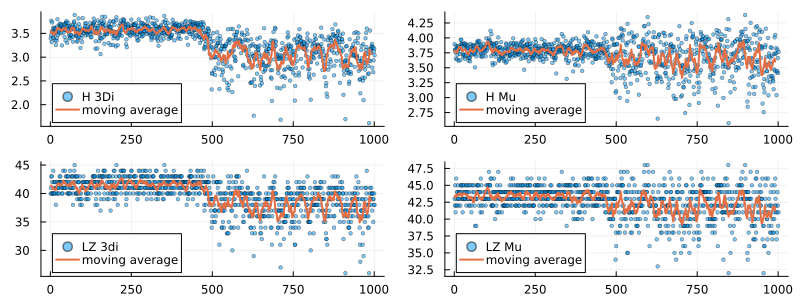

In [107]:
function pltdots(x, label, mk=2, alpha=.5, wsize=10)
    
    moving_average = [mean(x[i:i+wsize]) for i in 1:length(x)-wsize]

    p = plot(x, seriestype = :scatter, markersize = mk, alpha = alpha, label=label)
    p = plot!(moving_average, linewidth = 2, alpha = 1, label="moving average")

    return p
end

p1 = pltdots(traj3di.H1_fold, "H 3Di")
p2 = pltdots(trajmu.H1_fold, "H Mu")
p3 = pltdots(traj3di.lz, "LZ 3di" )
p4 = pltdots(trajmu.lz, "LZ Mu")

plot(p1, p2, p3, p4, layout = (2,2), size = (800, 300))

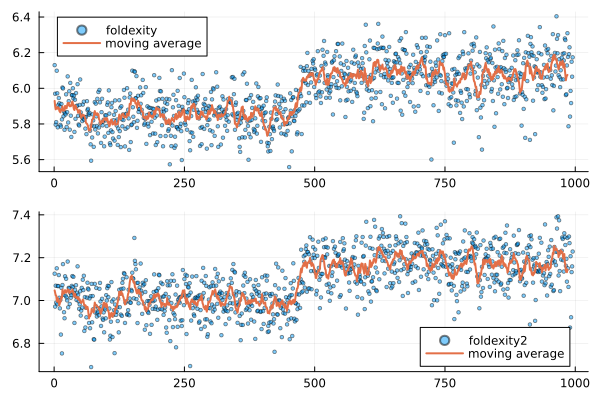

In [116]:
p1 = pltdots(fxdata.fxity, "foldexity")
p2 = pltdots(fxdata2.fxity, "foldexity2")
plot(p1, p2, layout=(2,1))

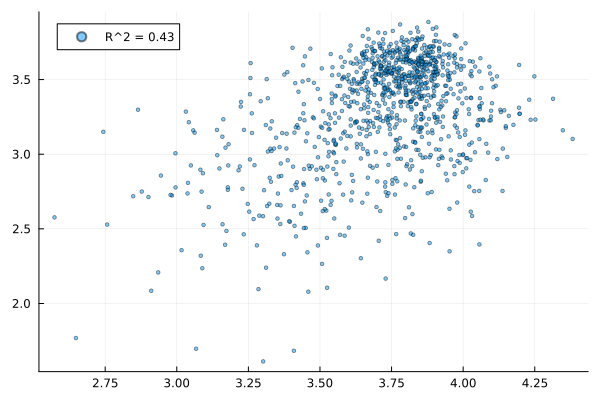

In [113]:
function scatter_corr(x, y)    
    s = scatter(x, y, label="R^2 = $(round(cor(x, y), sigdigits=2))", markershape=:circle, markersize = 2, alpha=0.5)
    return s
end

scatter_corr(trajmu.H1_fold, traj3di.H1_fold)